In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import platform
import matplotlib.pyplot as plt

In [7]:

# Define Transformer model
class TransformerModel(nn.Module):
  def __init__(self, input_dim, output_dim, d_model=128, nhead=4, num_layers=3, dim_feedforward=256, dropout=0.1):
    super(TransformerModel, self).__init__()
    self.encoder = nn.Linear(input_dim, d_model)
    self.transformer = nn.Transformer(
      d_model=d_model,
      nhead=nhead,
      num_encoder_layers=num_layers,
      num_decoder_layers=num_layers,
      dim_feedforward=dim_feedforward,
      dropout=dropout,
      batch_first=True
    )
    self.decoder = nn.Linear(d_model, output_dim)
    self.activation = nn.ReLU()

  def forward(self, src, tgt):
    src = self.activation(self.encoder(src))
    tgt = self.activation(self.encoder(tgt))
    out = self.transformer(src, tgt)
    return self.decoder(out)



In [8]:
# Hyperparameters
input_dim = 1
output_dim = 1
sequence_length = 10  # Sequence length for the Transformer
batch_size = 64
epochs = 100
learning_rate = 1e-3

device = torch.device(
  "mps" if platform.system() == "Darwin" and torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


/var/folders/d5/xpz_gp492yj9zsh2lty_0t180000gn/T/ipykernel_89980/3809533741.py:10: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  "mps" if platform.system() == "Darwin" and torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")


In [9]:
# Load data
# Prepare data per @Anna
opened = []
csv_path = 'data/CSV/'
masterlist = 'data/ALL_STATIONS_FINAL_REVISED.csv'

stations_df = pd.read_csv(masterlist)
station_num = stations_df['grdc_no']

arrayFile = [os.path.join(csv_path, f"{station_no}.csv") for station_no in station_num]

for file in arrayFile:
  df = pd.read_csv(file, index_col= None, header = 0)
  opened.append(df)

total_df = pd.concat(opened, axis = 0, ignore_index = True)

q = total_df['Q']
swe = total_df['SWE']
scaled = total_df['SWE_scaled']

# Convert q and swe to NumPy arrays
X = scaled.to_numpy()  # This will be 1D: shape (num_samples,)
y = q.to_numpy()

# Assume X and y are your 1D time series arrays
# Step 1: Replace zeros with a small value
X[X == 0] = 1e-9
y[y == 0] = 1e-9

# Step 2: Reshape data (if needed)
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

# Step 3: Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X = X_scaled
y = y_scaled
X, y = X[:len(X) - len(X) % sequence_length], y[:len(y) - len(y) % sequence_length]
X = X.reshape(-1, sequence_length, input_dim)
y = y.reshape(-1, sequence_length, output_dim)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = torch.tensor(X_train, dtype=torch.float32, device=device), torch.tensor(X_test, dtype=torch.float32,
                                                                                          device=device)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32, device=device), torch.tensor(y_test, dtype=torch.float32,
                                                                                          device=device)
# describe the data
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: torch.Size([1844, 10, 1]), y_train.shape: torch.Size([1844, 10, 1])
X_test.shape: torch.Size([461, 10, 1]), y_test.shape: torch.Size([461, 10, 1])


In [10]:
# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model checkpoint loaded from transformer_model_checkpoint.pth
Test Loss: 0.0001


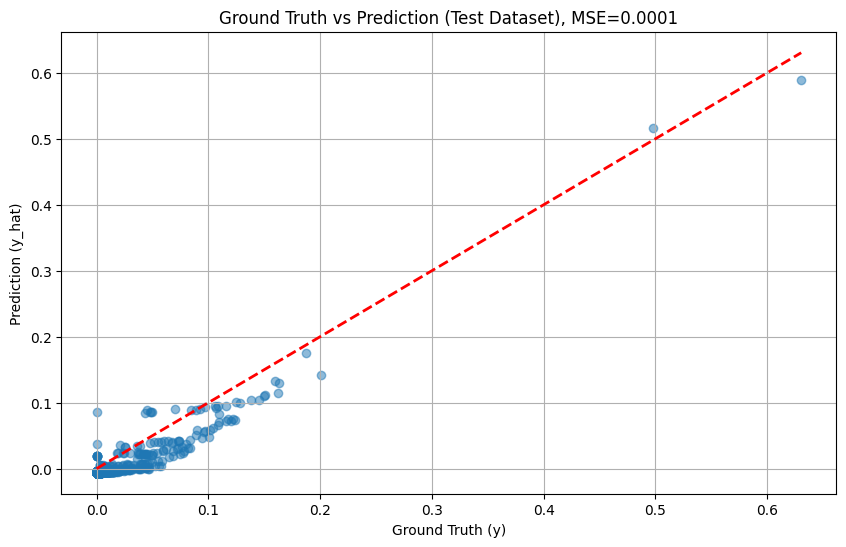

Full Dataset Loss: 0.0001


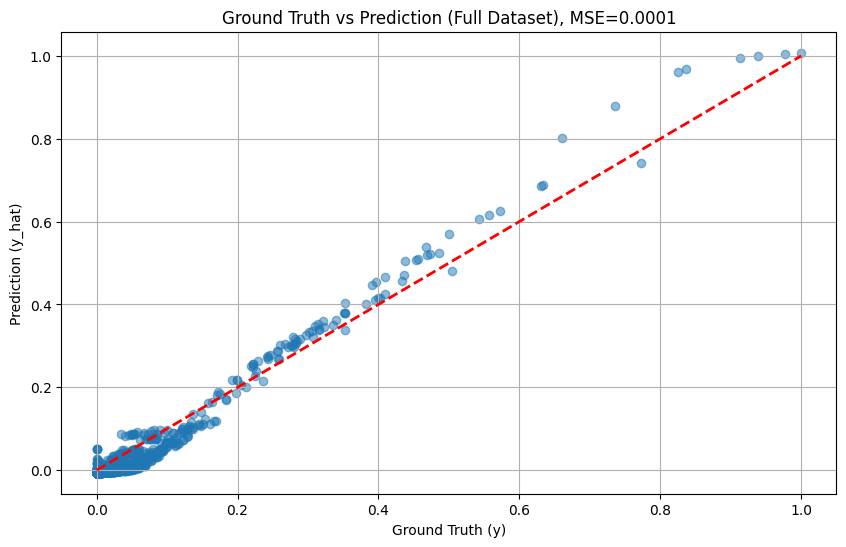

In [11]:


# Load checkpoint
checkpoint_path = "transformer_model_checkpoint.pth"
model = TransformerModel(input_dim, output_dim).to(device)
model.load_state_dict(torch.load(checkpoint_path))
criterion = nn.MSELoss()
print(f"Model checkpoint loaded from {checkpoint_path}")

# Set model to evaluation mode
model.eval()

# Evaluation on test dataset
y_preds_test = []  # To store predictions for test set
with torch.no_grad():
    test_loss = 0
    for batch_x, batch_y in test_loader:
        output = model(batch_x, batch_y)
        loss = criterion(output, batch_y)
        test_loss += loss.item()
        y_preds_test.append(output.cpu().numpy())  # Store predictions
    
    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")

# Convert predictions and ground truth to NumPy arrays for plotting
y_preds_test = np.concatenate(y_preds_test, axis=0)  # Concatenate all batches
y_true_test = y_test.cpu().numpy()

# Scatter Plot: Ground Truth vs Prediction (Test Dataset)
plt.figure(figsize=(10, 6))
plt.scatter(y_true_test.flatten(), y_preds_test.flatten(), alpha=0.5)
plt.xlabel("Ground Truth (y)")
plt.ylabel("Prediction (y_hat)")
plt.title(f"Ground Truth vs Prediction (Test Dataset), MSE={avg_test_loss:.4f}")
plt.grid(True)
plt.plot([y_true_test.min(), y_true_test.max()], [y_true_test.min(), y_true_test.max()], 'r--', lw=2)  # Line y=x for reference
plt.show()

# Evaluation on full dataset
full_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
y_preds_full = []  # To store predictions for full set
with torch.no_grad():
    full_loss = 0
    for batch_x, batch_y in full_loader:
        output = model(batch_x, batch_y)
        loss = criterion(output, batch_y)
        full_loss += loss.item()
        y_preds_full.append(output.cpu().numpy())  # Store predictions
    
    avg_full_loss = full_loss / len(full_loader)
    print(f"Full Dataset Loss: {avg_full_loss:.4f}")

# Convert predictions and ground truth to NumPy arrays for plotting
y_preds_full = np.concatenate(y_preds_full, axis=0)  # Concatenate all batches
y_true_full = y_train.cpu().numpy()

# Scatter Plot: Ground Truth vs Prediction (Full Dataset)
plt.figure(figsize=(10, 6))
plt.scatter(y_true_full.flatten(), y_preds_full.flatten(), alpha=0.5)
plt.xlabel("Ground Truth (y)")
plt.ylabel("Prediction (y_hat)")
plt.title(f"Ground Truth vs Prediction (Full Dataset), MSE={avg_full_loss:.4f}")
plt.grid(True)
plt.plot([y_true_full.min(), y_true_full.max()], [y_true_full.min(), y_true_full.max()], 'r--', lw=2)  # Line y=x for reference
plt.show()
